---
# Part 1, Discussion of 10,000 spills files
Plot spill locations relavent to regional impact.
**I broke this code when tidying up for publication and need to fix**

---

Spill files generated on [Digital Research Alliance of Canada](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://alliancecan.ca/en&ved=2ahUKEwi5npbTx86OAxU-CTQIHbQPDOsQFnoECA8QAQ&usg=AOvVaw08Yp1H1fiIsvct5I2kJu1_) HPC using `spillLocationsByImpactRegion.ipynb` have been archived in `aggregated_spills_output/SpillLocationImpacts`  folder of [FRDR data repository](https://doi.org/10.20383/103.01353).

## Environment Setup

Install required packages using the provided environment file:
```bash
conda env create -f ../environment.yaml
conda activate midoss_env
```

*Ensure the dataset and code repositories are in the same root folder:*
```
root_folder/
├── MuellerEtAl_MIDOSS_datasets/
└── MuellerEtAl_MIDOSS_code/   # (this repository)
```

## Review of information on volume limits
### Tankers
Capacity, length and hfo_to_diesel comparisons from [This website](https://silo.tips/download/suezmax-oil-tanker-tankers-166300-dwt#)
which Iain Braidwood has verified as having reasonable values. 

From `oil_attribution.ipynb`: Minimun tanker cargo capacity is 7,593,628 liters, based on small tanker size, and Maximum tanker cargo capacity is 185,447,000 liters: Corresponding to tank capacity of Suez-Max tankers as AIS data shows tanker lengths up to 287 m

### ATB cargo 
Based on information on Harley Marine Services for tank barges that received oil cargo from WA oil refineries 
in 2018, as shown in Dept. of Ecology database.  
See the OilCapacity tab in our `ATB_MMSIs` spreadsheet

- **Max cargo** Capacity based on Nancy Peterkin, **Kirby 185-01** (185,000 bbls = 28,300.22 m3)
- **Min cargo** capacity based on Harley Marine tank barge **Investigator** (16,007 bbls = 2,544.95 m3)

The `Origin_Destination_Analysis_Spreadsheet.xlsx` shows vessel lengths for oil tank ATBs in AIS ranging from 23 m - 209 m. There are two clear categories: 
1. lengths < 50 m, 
2. lengths > 140 m.  

We treat the former as reflecting lengths of the tug-only and the latter as reflecting lengths of tug-barge coupling.  We reviewed the MMSI for these cases and found no instances in which an MMSI reported sometimes < 50 m and other times as > 140 m (or visa versa).  These different recordings appear to be reliable and specific to a particular MMSI.  

From `oil_attribution.ipynb`: Minimum ATB cargo volume is set to 4,000,000 liters based on the smallest load of known ATBs (Island Trader: oil_capacity.xlsx).  Maximum ATB cargo volume is set to 29,413,150 liters based on the largest load of known ATBs (Kirby 185-01: oil_capacity.xlsx).  NOTE: There are different estimates of Kirby 185-01 volumes.  This difference is because some reportings use a % of maximum ~96% as maximum volume.  Our upper bound is based on 100% capacity.


### Barge cargo
vessel length ranges from 0m to 100m.  There are 36 non-ATB tugs with a reported length of 0m. 6 out of 401 vessels report a length greater than 50m.  

From `oil_attribution.ipynb`: Minimum barge cargo volume is set to 1,500,000 liters based on value of 1,589,900 liters in  3A-10 of [ECY report](https://fortress.wa.gov/ecy/publications/documents/96250.pdf), and maximum barge cargo volume is set to 32,000,000 liters based on value of 31,797,444 of 3A-10 of [ECY report](https://fortress.wa.gov/ecy/publications/documents/96250.pdf)

In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
from pathlib import Path
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import cartopy.crs
from cartopy import feature
import yaml

mpl.rc('font', size=11)
# some of the following may be repetetive but can also be set relative to the font value above 
#    (eg "xx-small, x-small,small, medium, large, x-large, xx-large, larger, or smaller"; see link above for details)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('legend', fontsize=12)
mpl.rc('axes', titlesize=16)
mpl.rc('axes', labelsize=12)
mpl.rc('figure', titlesize=16)
mpl.rc('text', usetex=False)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

In [2]:
# define directory paths
graphics_directory = Path('../')

# Aggregated spills files (created on Digital Alliance HPC)
spill_file_dir = Path('../../MuellerEtAl_MIDOSS_datasets/spill_files')

# Load Oil Attribution file 
oil_attribution_file = '../../MuellerEtAl_MIDOSS_datasets/oil_attribution_yaml_files/oil_attribution.yaml'

# create list of spill files to plot/evaluate
filenames = sorted(glob(os.path.join(spill_file_dir,"*.csv")))

with open(oil_attribution_file) as file:
        oil_attrs = yaml.load(file, Loader=yaml.Loader)

# conversion factors
gal2m3 = 0.00378541
liter2m3 = 1e-3

# oil attributions 
vessel_types = ['atb', 'barge', 'tanker','cargo','cruise','ferry','fishing','other','smallpass']

oil_types = [
    'akns', 
    'bunker', 
    'dilbit', 
    'jet', 
    'diesel', 
    'gas', 
    'other'
]
oil_labels = [
    'ANS', 
    'Bunker-C', 
    'Dilbit', 
    'Jet', 
    'Diesel', 
    'Gas', 
    'Other (Bunker-C)'
]
oil_colors = [
    'darkolivegreen',
    'olivedrab',
    'slategrey',
    'indigo',
    'mediumslateblue',
    'cornflowerblue',
    'saddlebrown'
]

df0 = pd.read_csv(filenames[0])
df0.head(1)

df0['Lagrangian_template'] = df0['Lagrangian_template'].replace(
    ['Lagrangian_akns.dat','Lagrangian_bunker.dat',
     'Lagrangian_diesel.dat','Lagrangian_gas.dat',
     'Lagrangian_jet.dat','Lagrangian_dilbit.dat',
     'Lagrangian_other.dat'], 
    ['ANS','Bunker-C','Diesel','Gasoline','Jet Fuel', 'Dilbit', 'Other (Bunker-C)']
)

In [3]:
filenames.pop(0)
filenames

['../../MuellerEtAl_MIDOSS_datasets/spill_files/SalishSea_oil_spills_1.csv',
 '../../MuellerEtAl_MIDOSS_datasets/spill_files/SalishSea_oil_spills_2.csv',
 '../../MuellerEtAl_MIDOSS_datasets/spill_files/SalishSea_oil_spills_3.csv',
 '../../MuellerEtAl_MIDOSS_datasets/spill_files/SalishSea_oil_spills_4.csv',
 '../../MuellerEtAl_MIDOSS_datasets/spill_files/SalishSea_oil_spills_5.csv',
 '../../MuellerEtAl_MIDOSS_datasets/spill_files/SalishSea_oil_spills_6.csv',
 '../../MuellerEtAl_MIDOSS_datasets/spill_files/SalishSea_oil_spills_7.csv',
 '../../MuellerEtAl_MIDOSS_datasets/spill_files/SalishSea_oil_spills_8.csv',
 '../../MuellerEtAl_MIDOSS_datasets/spill_files/SalishSea_oil_spills_9.csv']

### Load 100,000 spills files

In [4]:
df={}
for index,fn in enumerate(filenames):
    print(index,fn)
    df[index] = pd.read_csv(fn)
    # rename lagrangian files as oil types (for plotting)
    df[index]['Lagrangian_template'] = df[index]['Lagrangian_template'].replace(
        ['Lagrangian_akns.dat','Lagrangian_bunker.dat',
             'Lagrangian_diesel.dat','Lagrangian_gas.dat',
             'Lagrangian_jet.dat','Lagrangian_dilbit.dat',
             'Lagrangian_other.dat'], 
        ['ANS','Bunker-C','Diesel','Gasoline',
             'Jet Fuel', 'Dilbit', 'Other (Bunker-C)']
    )
    if index == 0:
        df_combined = df[index].copy()
    else:
        df_combined = pd.concat([df_combined, df[index]])

0 ../../MuellerEtAl_MIDOSS_datasets/spill_files/SalishSea_oil_spills_1.csv
1 ../../MuellerEtAl_MIDOSS_datasets/spill_files/SalishSea_oil_spills_2.csv
2 ../../MuellerEtAl_MIDOSS_datasets/spill_files/SalishSea_oil_spills_3.csv
3 ../../MuellerEtAl_MIDOSS_datasets/spill_files/SalishSea_oil_spills_4.csv
4 ../../MuellerEtAl_MIDOSS_datasets/spill_files/SalishSea_oil_spills_5.csv
5 ../../MuellerEtAl_MIDOSS_datasets/spill_files/SalishSea_oil_spills_6.csv
6 ../../MuellerEtAl_MIDOSS_datasets/spill_files/SalishSea_oil_spills_7.csv
7 ../../MuellerEtAl_MIDOSS_datasets/spill_files/SalishSea_oil_spills_8.csv
8 ../../MuellerEtAl_MIDOSS_datasets/spill_files/SalishSea_oil_spills_9.csv


In [5]:
print(f"Total volume of spills in Puget Sound (approx.): {df[3][df[3].spill_lat<48.148]['spill_volume'].sum()} liters")
print(f"Median volume of spills in Puget Sound (approx.): {df[3][df[3].spill_lat<48.148]['spill_volume'].median()} liters")
print(f"Max volume of spills in Puget Sound (approx.): {df[3][df[3].spill_lat<48.148]['spill_volume'].max()} liters")


Total volume of spills in Puget Sound (approx.): 413305039.1810033 liters
Median volume of spills in Puget Sound (approx.): 9607.885494397597 liters
Max volume of spills in Puget Sound (approx.): 18850000.0 liters


In [6]:
df[index][['spill_volume','Lagrangian_template']].groupby('Lagrangian_template').sum()

,spill_volume
Lagrangian_template,
ANS,6.431348e+08
Bunker-C,1.097501e+09
Diesel,9.985479e+08
Dilbit,1.708000e+07
Gasoline,2.512536e+08
Jet Fuel,9.689354e+07
Other (Bunker-C),2.121942e+08


In [7]:
plot_df = df[0][['spill_volume','Lagrangian_template']].groupby('Lagrangian_template').sum()
plot_df = plot_df.rename(columns={'spill_volume':0})    
for index in range(1,len(filenames)):
    print(index)
    plot_df[index]=df[index][['spill_volume','Lagrangian_template']].groupby('Lagrangian_template').sum()

1
2
3
4
5
6
7
8


In [8]:
plot_df

,0,1,2,3,4,5,6,7,8
Lagrangian_template,,,,,,,,,
ANS,3.989567e+08,4.580198e+08,5.740982e+08,5.664997e+08,7.743527e+08,3.712767e+08,7.684448e+08,3.358490e+08,6.431348e+08
Bunker-C,1.041574e+09,1.062285e+09,1.108077e+09,1.058616e+09,1.042147e+09,1.010882e+09,1.134923e+09,1.167175e+09,1.097501e+09
Diesel,7.349026e+08,9.053378e+08,8.502411e+08,7.224731e+08,6.644434e+08,7.363371e+08,7.366750e+08,8.574557e+08,9.985479e+08
Dilbit,4.053403e+07,2.318000e+07,9.882000e+07,1.250000e+06,8.966856e+07,4.905081e+07,7.783256e+07,5.866740e+07,1.708000e+07
Gasoline,1.922510e+08,4.208539e+08,3.339501e+08,2.095766e+08,2.574210e+08,3.573719e+08,2.580917e+08,1.898333e+08,2.512536e+08
Jet Fuel,1.853786e+07,7.332830e+07,7.110522e+07,1.310031e+08,6.577042e+07,6.902465e+07,8.127753e+07,1.068080e+08,9.689354e+07
Other (Bunker-C),1.450210e+08,2.787284e+08,8.048722e+07,1.228995e+08,2.115801e+08,1.168451e+08,1.591972e+08,1.520739e+08,2.121942e+08


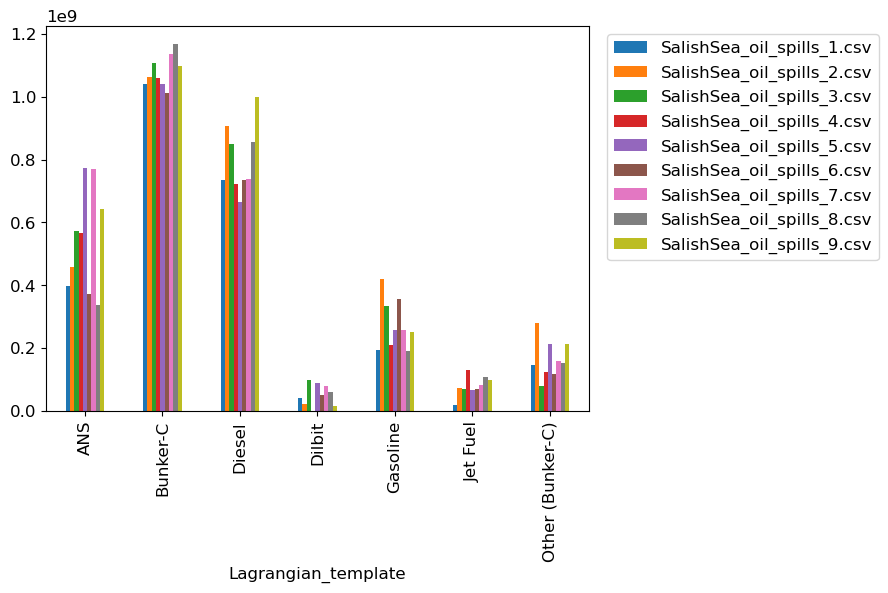

In [9]:
fig, axs = plt.subplots(1, 1,figsize=(7,5))
plot_df.plot(ax = axs, kind='bar')
L=plt.legend(bbox_to_anchor=(1.55, 1.0),loc=1)
for idx,name in enumerate(filenames):
    L.get_texts()[idx].set_text(name[-26:])
plt.savefig(graphics_directory/'spillvolume_by_oiltype_notcombined.png')

### Volume of spills by oil type

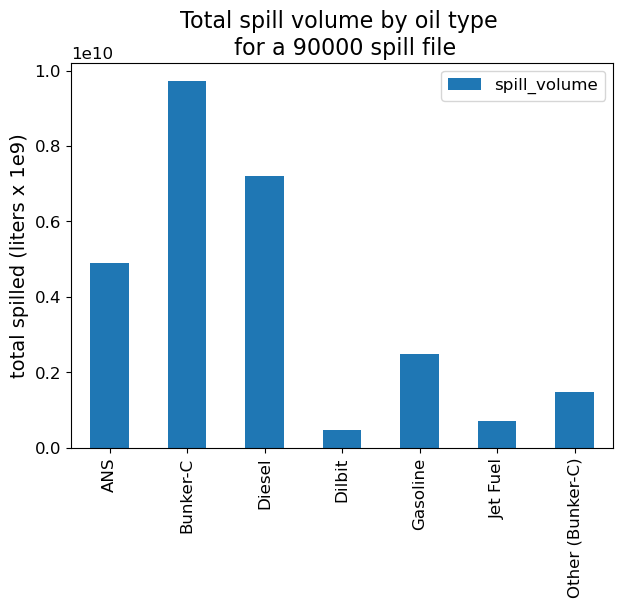

In [10]:
fig, axs = plt.subplots(1, 1,figsize=(7,5))
df_combined[['spill_volume','Lagrangian_template']].groupby('Lagrangian_template').sum().plot(ax = axs, kind='bar')
#axs.set_xticklabels(['akns', 'bunker', 'diesel', 'dilbit', 'gas', 'jet', 'other'])
axs.set_xlabel('')
axs.set_ylabel('total spilled (liters x 1e9)', fontsize=14)
axs.set_title(f"Total spill volume by oil type \n for a {10000*len(filenames)} spill file")
plt.savefig(graphics_directory/'spillvolume_by_oiltype.png')

### Number of spills and spill volume by vessel type

0 ../../MuellerEtAl_MIDOSS_datasets/spill_files/SalishSea_oil_spills_1.csv
1 ../../MuellerEtAl_MIDOSS_datasets/spill_files/SalishSea_oil_spills_2.csv
2 ../../MuellerEtAl_MIDOSS_datasets/spill_files/SalishSea_oil_spills_3.csv
3 ../../MuellerEtAl_MIDOSS_datasets/spill_files/SalishSea_oil_spills_4.csv
4 ../../MuellerEtAl_MIDOSS_datasets/spill_files/SalishSea_oil_spills_5.csv
5 ../../MuellerEtAl_MIDOSS_datasets/spill_files/SalishSea_oil_spills_6.csv
6 ../../MuellerEtAl_MIDOSS_datasets/spill_files/SalishSea_oil_spills_7.csv
7 ../../MuellerEtAl_MIDOSS_datasets/spill_files/SalishSea_oil_spills_8.csv
8 ../../MuellerEtAl_MIDOSS_datasets/spill_files/SalishSea_oil_spills_9.csv


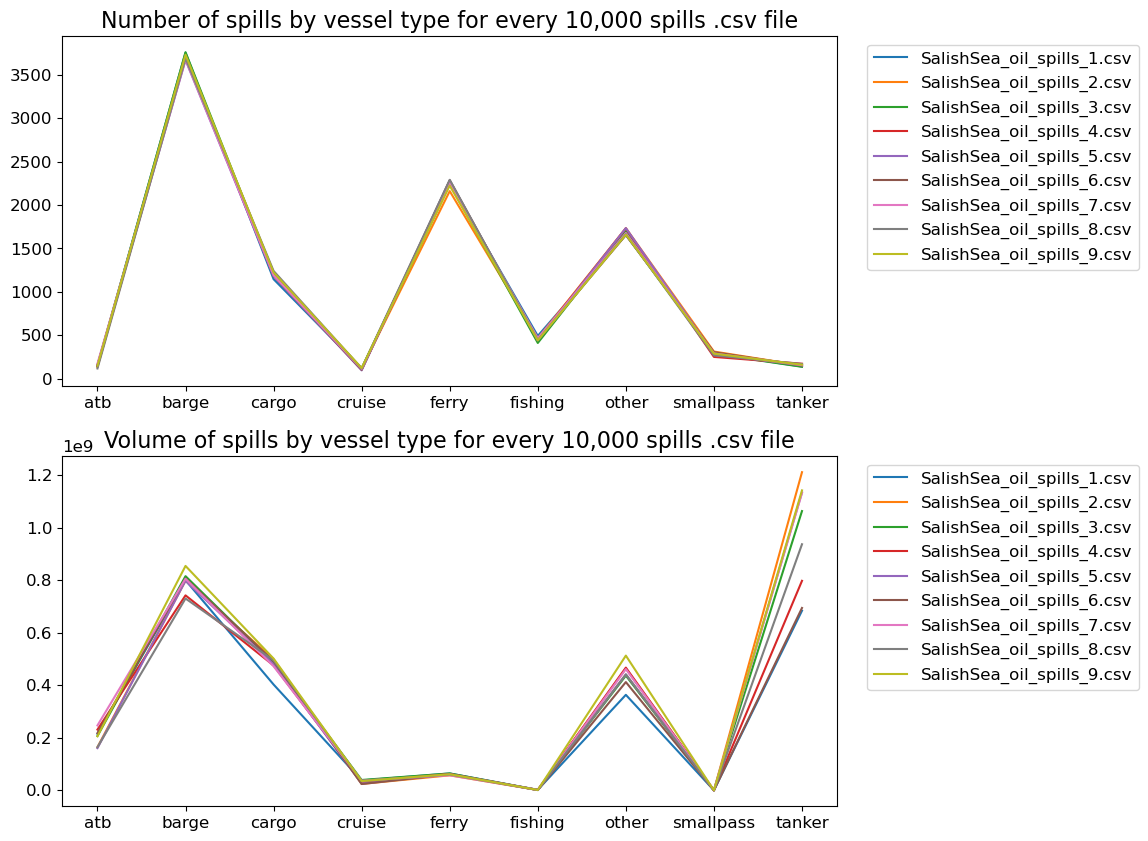

<Figure size 1000x1000 with 0 Axes>

In [11]:
# create dictionary to tally spills by vessel
df={}
spill_count = {}
spill_volume = {}
# loop through each 10,000 spill file and plot:
fig1 = plt.figure(figsize=(10, 10))
fig2 = plt.figure(figsize=(10, 10))
#1) spill count by vessel type
ax1 = fig1.add_subplot(211)
#2) spill volume by vessel type
ax2 = fig1.add_subplot(212)
for file_index,file in enumerate(filenames):
    print(file_index,file)
    df[file_index] = pd.read_csv(file)
    spill_count[file_index] = {}
    spill_volume[file_index]={}
    # calculate and catalogue spill count
    spill_count[file_index] = df[file_index][
            ['spill_volume','vessel_type']
        ].groupby('vessel_type').count()
    spill_count[file_index] = spill_count[file_index].rename(
        columns = {'spill_volume':'spill_count'}
    )
    # calculate and catalogue spill volume
    spill_volume[file_index] = df[file_index][
            ['spill_volume','vessel_type']
        ].groupby('vessel_type').sum()
    #ax = spill_count[file_index].spill_count[:].plot(label={'File #'file_index})
    ax1.plot(
        spill_count[file_index].spill_count[:],
        '-',
        label=f'{file[-26:]}',
    )
    ax2.plot(
        spill_volume[file_index].spill_volume[:],
        '-',
        label=f'{file[-26:]}'
    )
ax1.legend(bbox_to_anchor=(1.4, 1.0),loc=1)
ax2.legend(bbox_to_anchor=(1.4, 1.0),loc=1)
ax1.set_title('Number of spills by vessel type for every 10,000 spills .csv file')
ax2.set_title('Volume of spills by vessel type for every 10,000 spills .csv file')
fig1.savefig(graphics_directory/'spillvolume_by_vesseltype.png')

## Plot location of large spills by oil type and file

In [12]:
# sort the spills by volume
nrows=100
spill_locs_100 = {}
for file_index,file in enumerate(filenames):
    spill_locs = df[file_index].sort_values(
        by="spill_volume",
        ascending=False).reset_index(drop=True)
    # rename oil types to those represented in model runs
    spill_locs['Lagrangian_template'] = spill_locs['Lagrangian_template'].replace(
        ['Lagrangian_akns.dat','Lagrangian_bunker.dat',
             'Lagrangian_diesel.dat','Lagrangian_gas.dat',
             'Lagrangian_jet.dat','Lagrangian_dilbit.dat',
             'Lagrangian_other.dat'], 
        ['ANS','Bunker-C','Diesel','Diesel',
             'Diesel', 'Dilbit', 'Bunker-C']
    )
    # extract the first nrows
    spill_locs_100[file_index] = spill_locs.iloc[:nrows]

In [13]:
spill_locs_byoil = {}
oil_types = [
    'ANS', 
    'Bunker-C', 
    'Dilbit', 
    'Diesel'
]
for file_index,file in enumerate(filenames):
    spill_locs_byoil[file_index]={}
    for oil in oil_types:
        spill_locs_byoil[file_index]["{0}".format(oil)] = spill_locs_100[file_index][
            spill_locs_100[file_index].Lagrangian_template==oil
        ].sort_values(by='spill_volume')
        len_array = len(spill_locs_byoil[file_index][oil])
        #print(f'{oil}: {len_array}')

In [14]:
# determine max spill volume across all files
spill_volume_fraction = {}
max_spill_byfile = np.zeros(len(filenames))
for file_index,file in enumerate(filenames):
    max_spill_byfile[file_index] = max(
        spill_locs_100[file_index].spill_volume
    )
max_spill_volume = max(max_spill_byfile)

In [15]:
for file_index,file in enumerate(filenames):
    # Weight spill volumes by max volume for plotting 
    spill_volume_fraction[file_index] = spill_locs_100[file_index].spill_volume/max_spill_volume 

In [16]:
[*spill_locs_byoil[file_index]]

['ANS', 'Bunker-C', 'Dilbit', 'Diesel']

Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #491 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included b

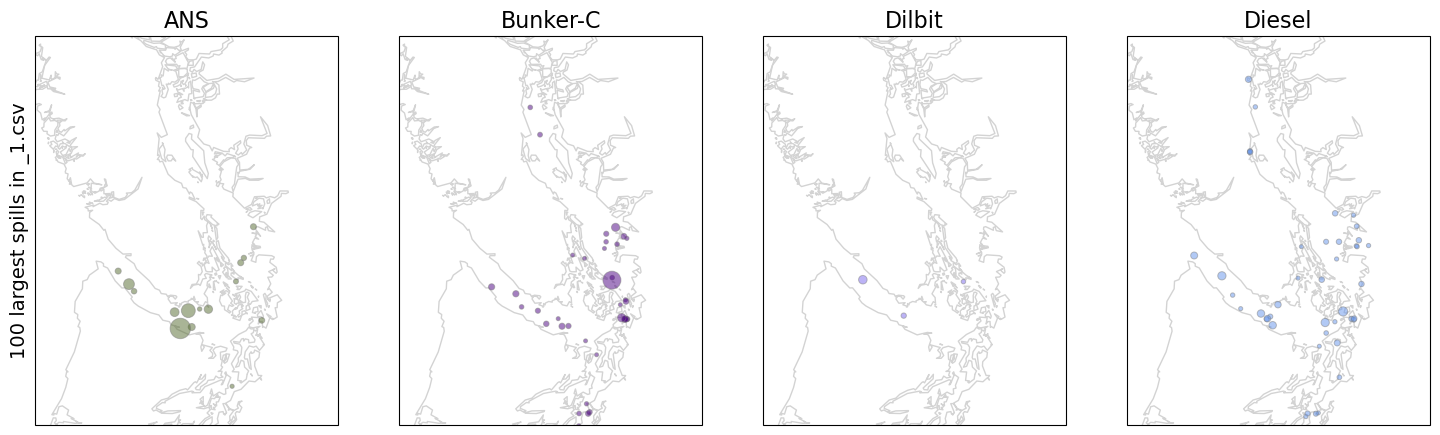

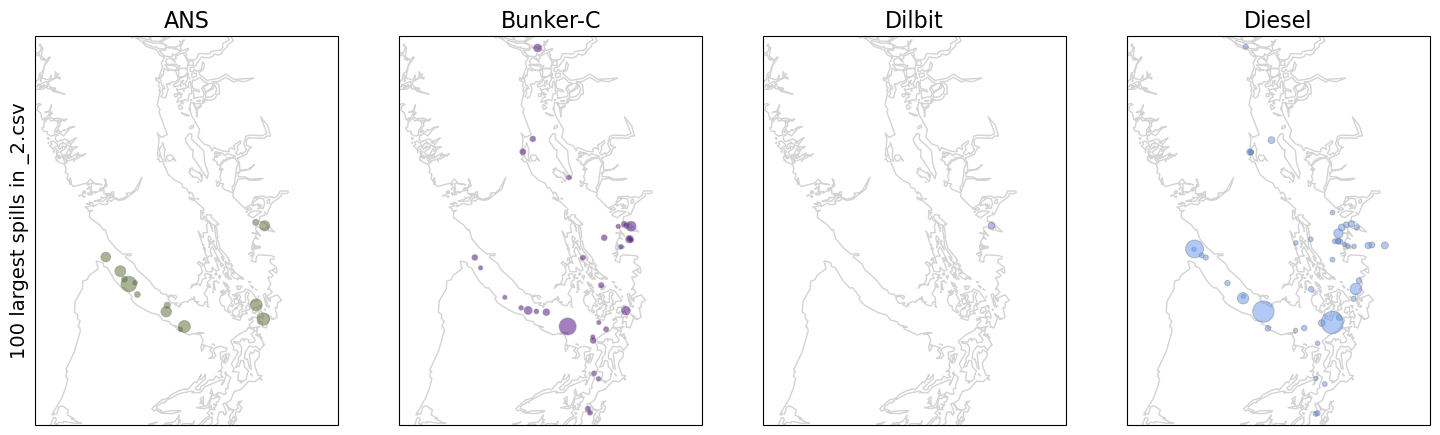

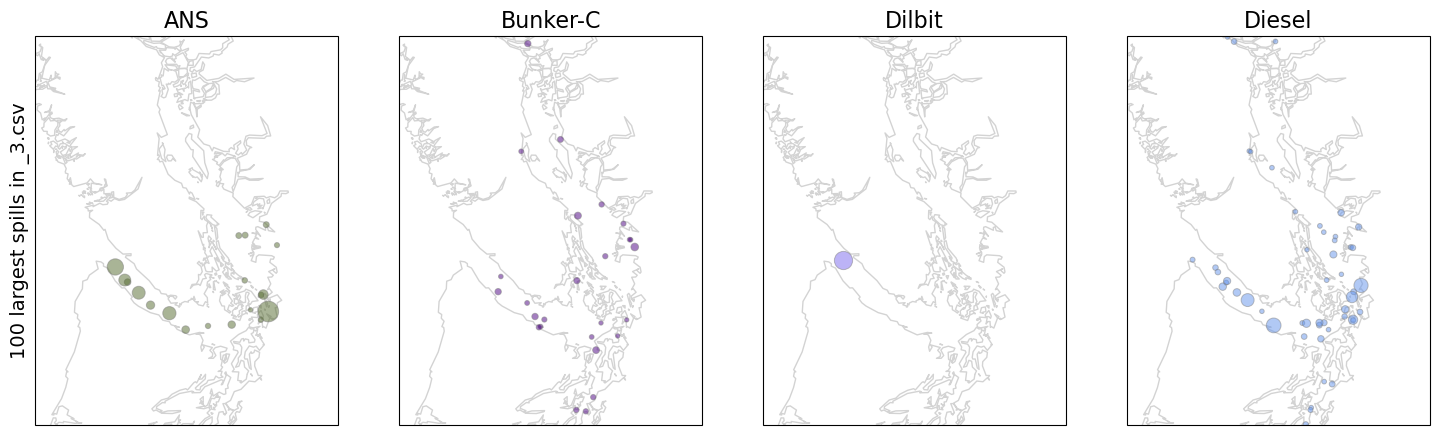

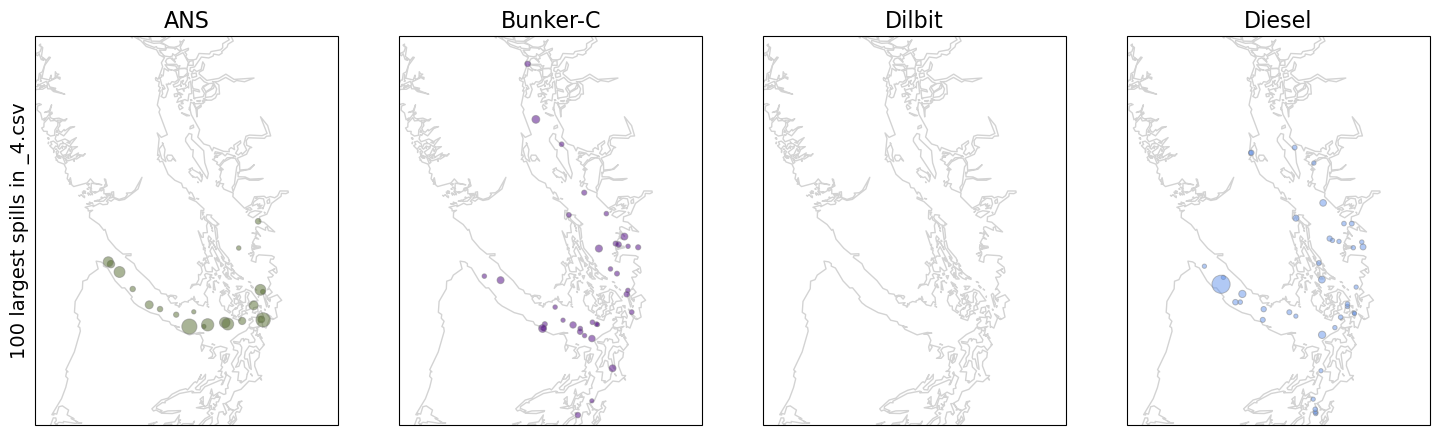

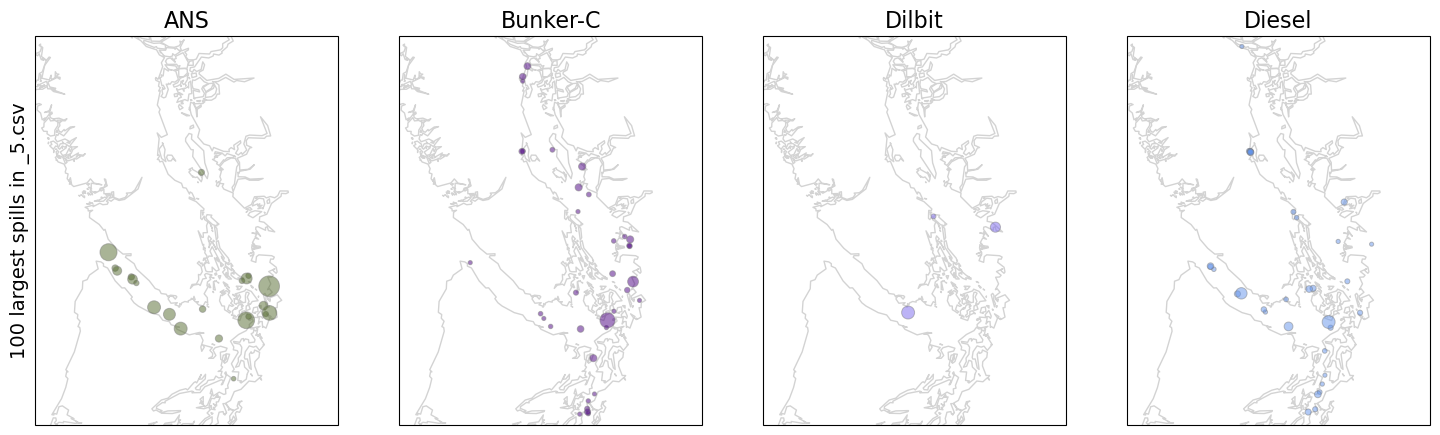

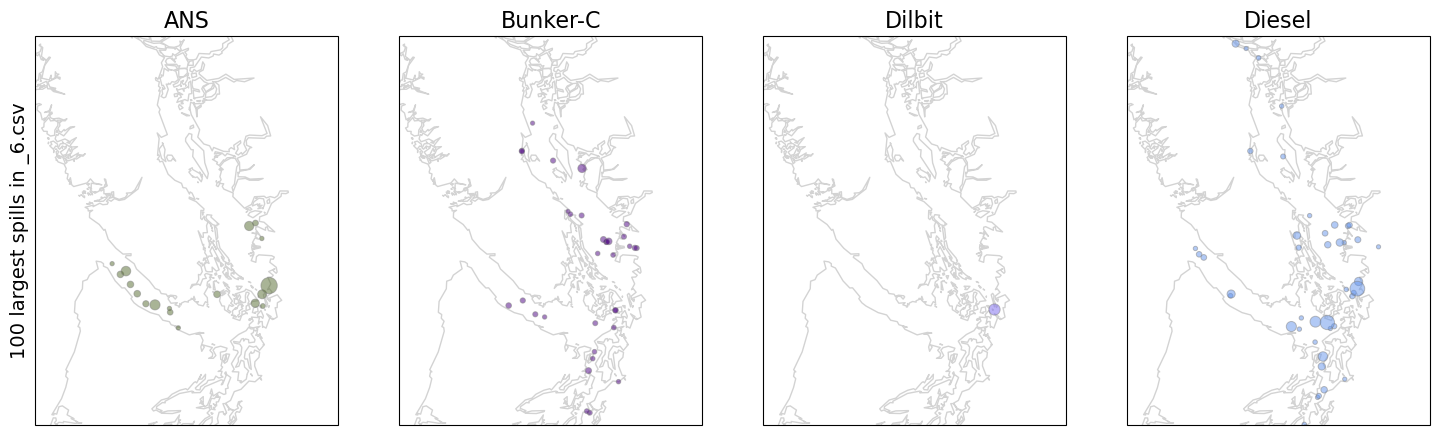

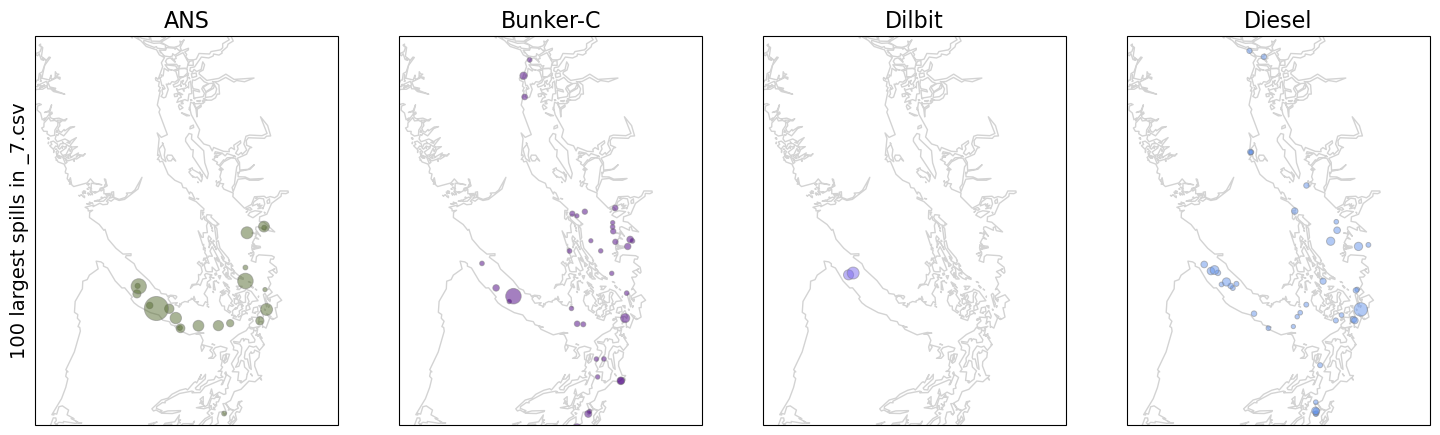

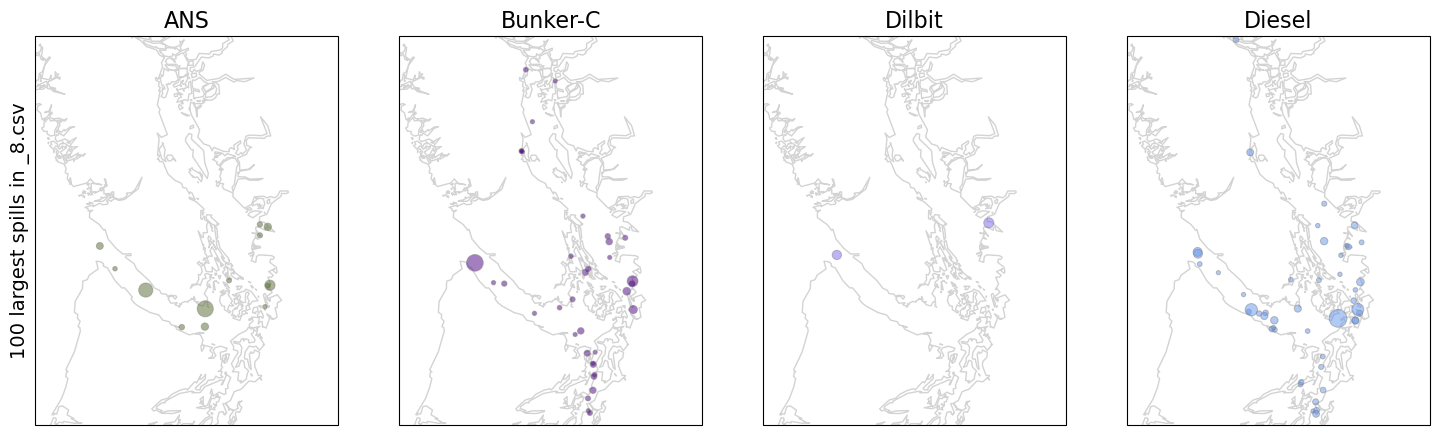

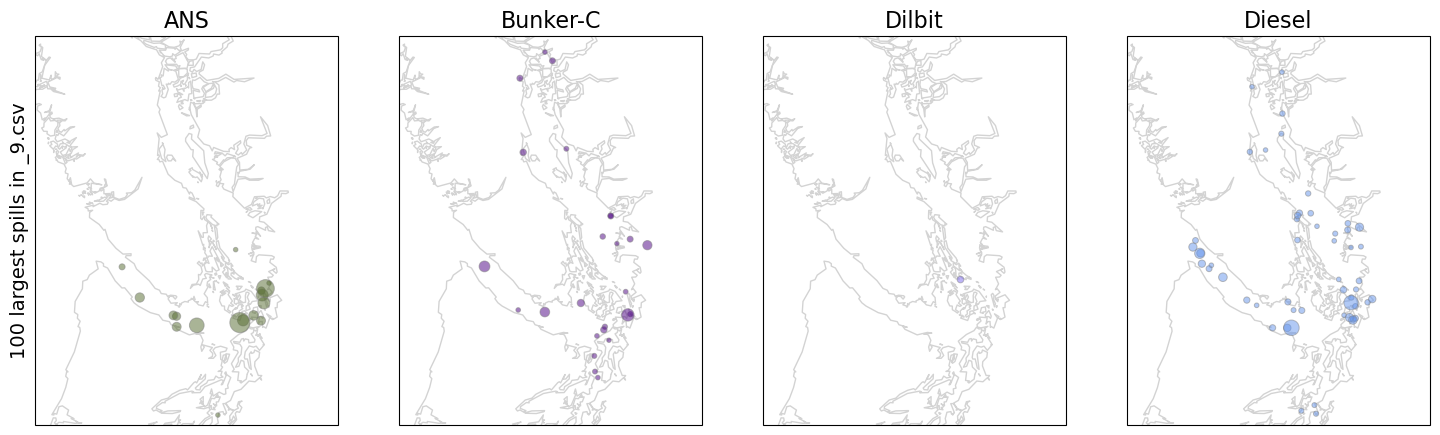

In [17]:
# define axis limits
axlim = np.zeros(4)
axlim[0] = -124.5
axlim[1] = -123.5
axlim[2] = spill_locs.spill_lat.min()
axlim[3] = spill_locs.spill_lat.max()

oil_colors = [
    'darkolivegreen',
    'indigo',
    'mediumslateblue',
    'cornflowerblue',
    'saddlebrown'
]
ms = 300

rotated_crs = cartopy.crs.RotatedPole(pole_longitude=120.0, pole_latitude=63.75)
plain_crs = cartopy.crs.PlateCarree()
from cartopy.io import shapereader as shpreader 
%matplotlib inline    
for file_index,file in enumerate(filenames):
    fig,axs = plt.subplots(
        1, 4, figsize=(18, 9), 
        subplot_kw={"projection": rotated_crs, "facecolor": "white"}
    )
    fig.subplots_adjust(hspace=0.5)
    terminal_loc = 0
    for plot_index,oil in enumerate([*spill_locs_byoil[file_index]]):
        spill_volume_fraction[file_index] = spill_locs_byoil[file_index][oil].spill_volume/max_spill_volume
 #       print(plot_index)
        axs[plot_index].add_feature(feature.GSHHSFeature(
            'auto', 
            edgecolor='lightgrey', 
            facecolor='none'
        ), zorder=1)
        scatter_bunker = axs[plot_index].scatter(spill_locs_byoil[file_index][oil].spill_lon, 
               spill_locs_byoil[file_index][oil].spill_lat, 
               s = ms * spill_volume_fraction[file_index],
               #label = spill_volume_fraction['bunker'].values.tolist(),
               color=oil_colors[plot_index],
               alpha = 0.5,
               edgecolors='grey',
               linewidth=0.7,
               transform=plain_crs,
               zorder=2)
    #     handles, labels = scatter_bunker.legend_elements(prop="sizes", color=oil_colors[1], num=3, alpha=1)
    #     legend = axs[plot_index].legend(handles, labels, loc="upper right", title="volume (liters)")
    #     plt.setp(legend.get_title(),fontsize='xx-large')
        axs[plot_index].set_title(oil)
        axs[plot_index].set_extent(axlim, crs=plain_crs)
    
    axs[0].text(-0.05,0.5,'100 largest spills in ' + filenames[file_index][-6:],
        rotation = 90,
        horizontalalignment='center',
        verticalalignment='center',
        transform = axs[0].transAxes,
        fontsize = 14)
    fig.canvas.draw()
    #fig.tight_layout()

    index += 1
    plt.show()

## Sort spills by oil type and ECY scenarios
- Worst case: Complete discharge of 3.5e7 gallons (1.24 m$^3$)
- Maximum most probable: Largest historical = 2.5e5 gallons (9.5e2 m$^3$)
- Most probable: "Average" spills up to 1e2 gallons (0.4 m$^3$)
---
- Max capacity SuezMax = 1.85e5 m$^3$
- Max capacity ATB = 3.0e4 m$^3$

In [18]:
# Convert ECY spill scenarios to m3
spill_case = {}
spill_case['worst']=3.5e7*gal2m3
spill_case['max_likely']=2.5e5*gal2m3
spill_case['most_likely']=1e2*gal2m3

combinedSpillVolume_m3 = liter2m3*df_combined[['spill_volume']]
P1 = len(combinedSpillVolume_m3[combinedSpillVolume_m3.spill_volume >spill_case['worst']])/len(combinedSpillVolume_m3)
P2 = len(
    combinedSpillVolume_m3[
        (combinedSpillVolume_m3.spill_volume <= spill_case['worst']) & 
        (combinedSpillVolume_m3.spill_volume > spill_case['max_likely'])
    ])/len(combinedSpillVolume_m3)
P3 = len(
    combinedSpillVolume_m3[
        (combinedSpillVolume_m3.spill_volume <= spill_case['max_likely']) & 
        (combinedSpillVolume_m3.spill_volume > spill_case['most_likely'])
    ])/len(combinedSpillVolume_m3)
P4 = len(
    combinedSpillVolume_m3[
        combinedSpillVolume_m3.spill_volume <= spill_case['most_likely']
    ])/len(combinedSpillVolume_m3)
percent_spills = {}
percent_spills['gt_worst'] = 100*P1
percent_spills['maxlikely_worst'] = 100*P2 
percent_spills['mostlikely_maxlikely'] = 100*P3
percent_spills['lt_mostlikely'] = 100*P4

print(f'Percent spills above ECY worst scenario: {percent_spills["gt_worst"]:.4f}%') 
print(f'Percent spills between max likely and worst: {percent_spills["maxlikely_worst"]:.2f}%') 
print(f'Percent spills between most likely and max likely: {percent_spills["mostlikely_maxlikely"]:.2f}%') 
print(f'Percent spills less than most likely: {percent_spills["lt_mostlikely"]:.2f}%') 

Percent spills above ECY worst scenario: 0.0033%
Percent spills between max likely and worst: 5.21%
Percent spills between most likely and max likely: 80.18%
Percent spills less than most likely: 14.61%


In [19]:
P1 = len(combinedSpillVolume_m3[combinedSpillVolume_m3.spill_volume >spill_case['worst']])/len(combinedSpillVolume_m3)
P2 = len(
    combinedSpillVolume_m3[
        (combinedSpillVolume_m3.spill_volume <= spill_case['worst']) & 
        (combinedSpillVolume_m3.spill_volume > spill_case['max_likely'])
                          ]
        )/len(combinedSpillVolume_m3)


In [20]:
print('ECY spill case volumes [m3]')
spill_case

ECY spill case volumes [m3]


{'worst': 132489.35, 'max_likely': 946.3525, 'most_likely': 0.378541}

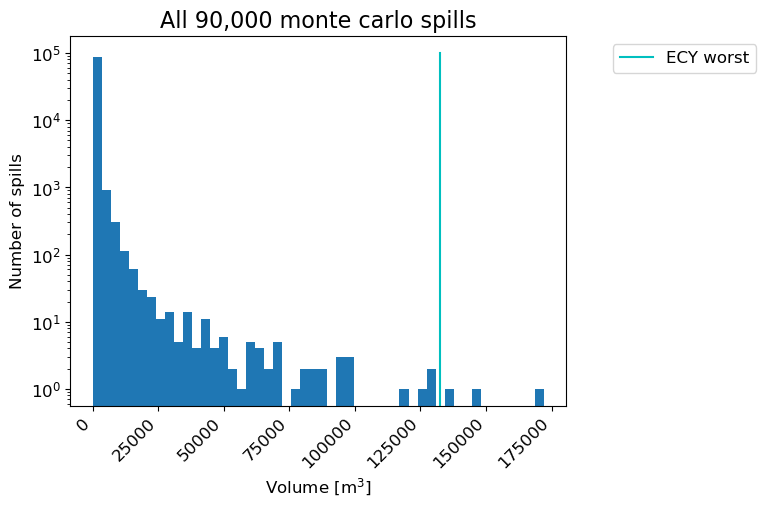

In [21]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
n, bins, patches = plt.hist(
    combinedSpillVolume_m3,
    log=True,
    bins=50
)
plt.plot((spill_case['worst'], spill_case['worst']),
         (0, 1e5),
         'c',
         label='ECY worst'
        )
plt.xlabel('Volume [m$^3$]')
plt.ylabel('Number of spills')
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
plt.legend(bbox_to_anchor=(1.4, 1.0),loc=1)
plt.title('All 90,000 monte carlo spills')
plt.savefig(graphics_directory/'numberSpills_by_volume.png')

Text(0.5, 1.0, 'Number of spills less than "worst case" scenario')

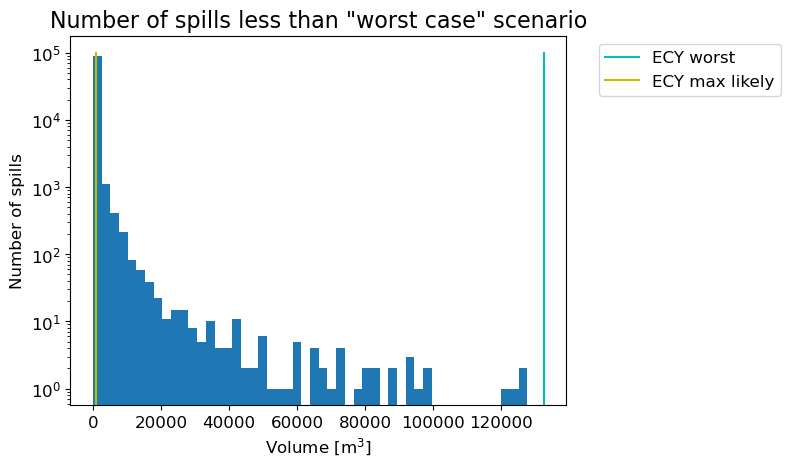

In [22]:
worst = combinedSpillVolume_m3.loc[combinedSpillVolume_m3.spill_volume<spill_case['worst']]
n, bins, patches = plt.hist(
    worst.spill_volume,
    log=True,
    bins=50
)
plt.plot((spill_case['worst'], spill_case['worst']),
         (0, 1e5),
         'c',
         label='ECY worst')
plt.plot((spill_case['max_likely'], spill_case['max_likely']),
         (0, 1e5),
         'y',
         label='ECY max likely')
plt.xlabel('Volume [m$^3$]')
plt.ylabel('Number of spills')
plt.legend(bbox_to_anchor=(1.45, 1.0),loc=1)
plt.title('Number of spills less than "worst case" scenario')

In [23]:
df_combined_sorted = {}
df_combined_sorted

{}

In [31]:
# for ix,bn in enumerate(bins):
#     print(f'{bn:.2e}',n[ix])

In [32]:
# fig, axs = plt.subplots(1, 1,figsize=(7,5))
# df_combined[['spill_volume']].hist(ax = axs)
# #axs.set_xticklabels(['akns', 'bunker', 'diesel', 'dilbit', 'gas', 'jet', 'other'])
# axs.set_xlabel('')
# axs.set_ylabel('spill volume (m$^3$)', fontsize=14)
# axs.set_title(f"Spill volumes by oil type \n for a {10000*len(filenames)} spill file")
# #plt.savefig(graphics_directory/'spillvolume_by_oiltype.png')

### Hypothesis: The spread in ATB spill volume among 10,000 run files is smaller than the other tank vessels because:
- the number of spills is much smaller than the barge category
- the maximum cargo capacity is an order of magnitude smaller than the tanker category

#### Plot ratio of spill volume to cargo capacity to test this hypothesis

In [25]:
cargo_spills = {}
for vessel in ['tanker','atb','barge']:
    cargo_spills[vessel] = df_combined.loc[
        (df_combined.fuel_cargo == 'cargo') &
        (df_combined.vessel_type == vessel),
        ['cargo_capacity', 'spill_volume', 'vessel_type']
    ]
    cargo_spills[vessel]['ratio'] = cargo_spills[vessel]['spill_volume']/cargo_spills[vessel]['cargo_capacity']

cargo_spills['tanker'].head()

,cargo_capacity,spill_volume,vessel_type,ratio
50,1.828353e+07,1.828353e+05,tanker,0.01
189,1.828353e+07,1.828353e+05,tanker,0.01
305,1.360931e+07,9.526514e+05,tanker,0.07
394,1.850000e+08,9.250000e+06,tanker,0.05
396,1.850000e+08,2.035000e+07,tanker,0.11


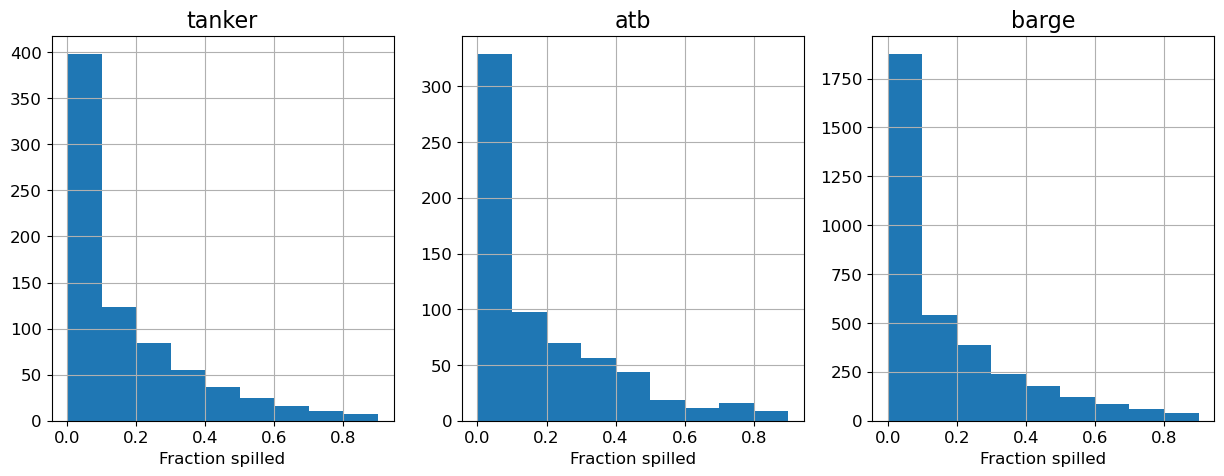

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for idx,vessel in enumerate(['tanker','atb','barge']):
    percent_bins = np.arange(0, 1, 0.1)
    cargo_spills[vessel]['ratio'].hist(ax=axs[idx],bins=percent_bins);
    axs[idx].set_xlabel('Fraction spilled');
    axs[idx].set_title(vessel)

### Evaluate the ATB, barge and tanker size classes

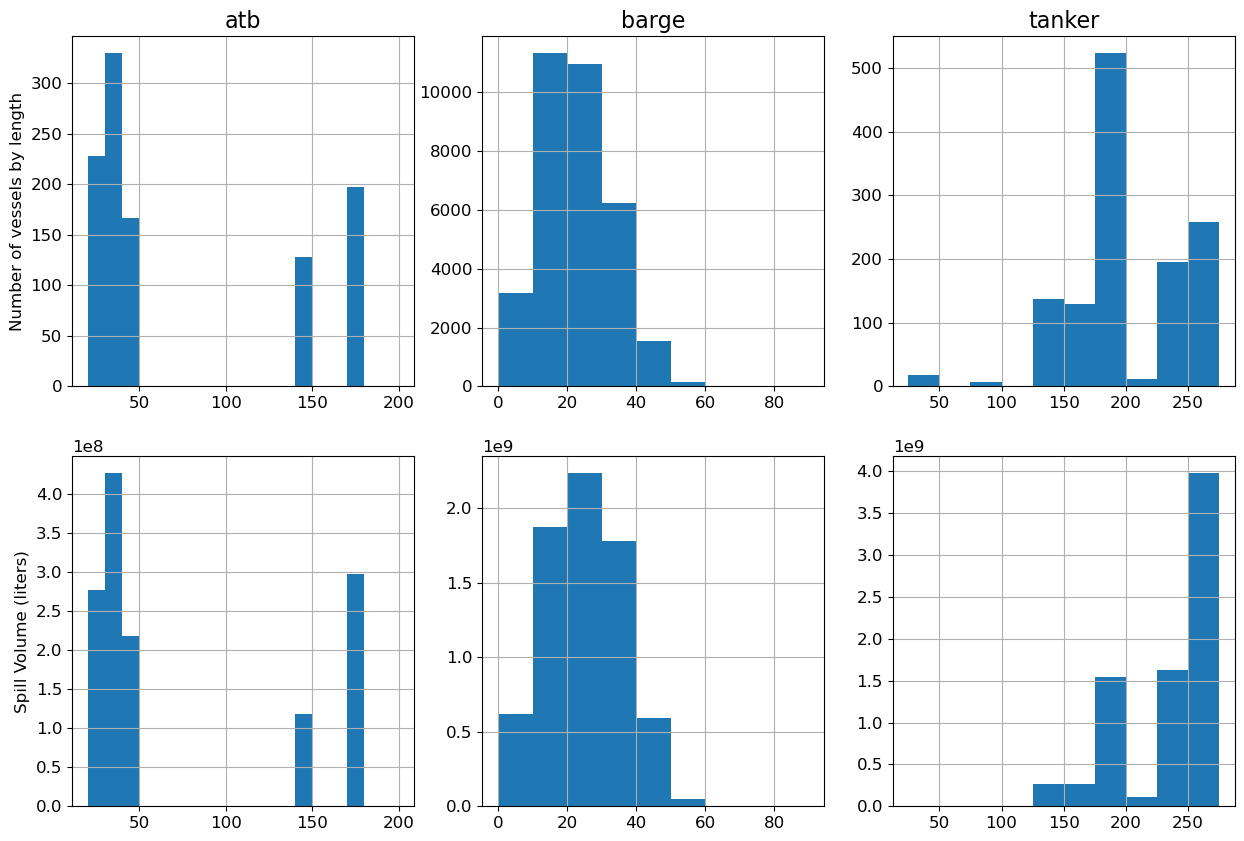

In [28]:
vessel_sizes={}

fig,axs = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
histbins = {}
histbins['atb'] = np.arange(20,210,10) 
histbins['barge'] = np.arange(0,100,10) 
histbins['tanker'] = np.arange(25,300,25) 

for idx_vessel,vessel in enumerate(['atb','barge','tanker']):
    # count number of spills by size class
    vessel_sizes[vessel] = df_combined.loc[
        (df_combined.vessel_type == vessel),
        ['vessel_len', 'spill_volume','cargo_capacity','fuel_capacity']
    ]
    # raw print for perspective
    #print(vessel_sizes[vessel]['count'])
    # plot histograms of number of spills and volume spilled by size class  
    vessel_sizes[vessel].vessel_len.hist(ax=axs[0,idx_vessel],bins=histbins[vessel]);
    vessel_sizes[vessel].vessel_len.hist(ax=axs[1,idx_vessel], bins=histbins[vessel], weights=vessel_sizes[vessel].spill_volume);
    axs[0,0].set_ylabel('Number of vessels by length');
    axs[1,0].set_ylabel('Spill Volume (liters)');
    axs[0,idx_vessel].set_title(vessel)

In [29]:
# print values for publication
#print(vessel_sizes['atb'].vessel_len(vessel_sizes[vessel].vessel_len < 50).count())
atb_lt_50 = vessel_sizes['atb']['vessel_len'].loc[
    vessel_sizes['atb']['vessel_len'] < 50
].count()
atb_130to210 = vessel_sizes['atb']['vessel_len'].loc[
    (vessel_sizes['atb']['vessel_len'] > 130) & 
    (vessel_sizes['atb']['vessel_len'] < 210)
].count()
print('---------  Monte Carlo (before length adjustment) --------------')
print(f'ATB count (< 50m): {atb_lt_50}')
print(f'ATB count (130 - 210 m):{atb_130to210}')
print(f'ATB ratio (< 50 m)/(130 - 210 m):{atb_lt_50/atb_130to210}')

---------  Monte Carlo (before length adjustment) --------------
ATB count (< 50m): 725
ATB count (130 - 210 m):593
ATB ratio (< 50 m)/(130 - 210 m):1.2225969645868466


In [33]:

!pip install openpyxl
# compare monte-carlo results to AIS

#~~~ atb traffic ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# fuel and cargo capacity information
# B: "FREQUENCY"
# C: "LENGTH"

atb_df = pd.read_excel(
    '/Users/rmueller/Data/MIDOSS/marine_transport_data/Origin_Destination_Analysis.xlsx',
    sheet_name='Vessel Length', 
    usecols='A,B,C',
    skiprows=2
)

atb_seglen = pd.read_excel(
    '/Users/rmueller/Data/MIDOSS/marine_transport_data/Origin_Destination_Analysis.xlsx',
    sheet_name='Frequency of AIS Pings', 
    usecols='A,B,C',
    skiprows=1
)
# set MMSI column to same name
atb_seglen = atb_seglen.rename(columns={"ATB MMSI":"MMSI"})
# join sheets
atb_df = pd.merge(
    left=atb_df, 
    right=atb_seglen, 
    on = "MMSI",
    how='left'
)

# < 50 m ATBs
atb_lt_50_ais = atb_df.loc[
   ( atb_df['LENGTH'] < 50),
    ['Number of vessel tracks',"Median segment length (km)"]
]
# scale number vessel tracks by segment lengths and sum 
atb_lt_50_ais_sum = (
    atb_lt_50_ais['Number of vessel tracks']*\
    atb_lt_50_ais["Median segment length (km)"]/\
    atb_lt_50_ais["Median segment length (km)"].mean()
).sum()

# Repeat fo 130-210 m ATBs
atb_130to210_ais = atb_df.loc[
    ( atb_df['LENGTH'] > 130) & 
    ( atb_df['LENGTH'] < 210),
    ['Number of vessel tracks',"Median segment length (km)"]
]
atb_130to210_ais_sum = (
    atb_130to210_ais['Number of vessel tracks']*\
    atb_130to210_ais["Median segment length (km)"]/\
    atb_130to210_ais["Median segment length (km)"].mean()
).sum()
print('---------  AIS (counts weighted by segment lengths) --------------')
print(f'ATB count (< 50m): {atb_lt_50_ais_sum}')
print(f'ATB count (130 - 210 m):{atb_130to210_ais_sum}')
print(f'ATB ratio (< 50 m)/(130 - 210 m):{atb_lt_50_ais_sum/atb_130to210_ais_sum}')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [openpyxl]
---------  AIS (counts weighted by segment lengths) --------------
ATB count (< 50m): 232471.15098174018
ATB count (130 - 210 m):272222.235055983
ATB ratio (< 50 m)/(130 - 210 m):0.8539756164074256


## Review oil_attribution.yaml and assumptions on barge and ATB oil attribution using voyage dataset

In [34]:
from monte_carlo_utils import make_bins, get_bin, place_into_bins, clamp
random_seed=None
# Initialize PCG-64 random number generator
random_generator = np.random.default_rng(random_seed)


# after reviewing the oil attribution file, I see that I have the weights and bins set to the ATB category
# load oil_attribution file to review specifications for ATBs and barges. 

# test the random generator 
cargo_weight = (
    oil_attrs['vessel_attributes']['barge']
    ['cargo_capacity_probability']
)
cargo_capacity_bin_centers =  (
    oil_attrs['vessel_attributes']['barge']
    ['cargo_capacity_bin_centers'] 
)
cargo_capacity = random_generator.choice(
    cargo_capacity_bin_centers, 
    p = cargo_weight
)

ModuleNotFoundError: No module named 'monte_carlo_utils'

In [ ]:
(oil_attrs["vessel_attributes"]["atb"]["min_cargo"] +  20810153.33)/ 236476.57

In [ ]:
print('cargo weights\n',cargo_weight)
#print()

In [ ]:
oil_attrs['vessel_attributes']['barge']

## Take-away: Vessel lengths varry in monte-carlo

In [ ]:
vessel_sizes['barge']

### Plot location of oil spills by vessel types and oil types

In [ ]:
# calculate maximum spill to use for weighting size of scatter dots
max_spill_volume = df_combined.spill_volume.max()

In [ ]:
scatter_oil = {}
spill_locs_byoil = {}
spill_volume_fraction = {}

for vessel in vessel_types:
    spill_locs_byoil[vessel] = {}
    spill_volume_fraction[vessel] = {}
    for oil in oil_labels:
        spill_locs_byoil[vessel][oil] = df_combined.loc[
            (df_combined.vessel_type == vessel) &
            (df_combined.Lagrangian_template == oil),
            ['spill_lat', 'spill_lon', 'spill_volume']
        ]
        spill_volume_fraction[vessel][oil] = spill_locs_byoil[vessel][oil].spill_volume/max_spill_volume


In [ ]:
for idx_vessel, vessel in enumerate(vessel_types):
    for idx_oil,oil in enumerate(oil_labels):
        test = np.log10(ms * spill_volume_fraction[vessel][oil])

In [ ]:
## rotated_crs = cartopy.crs.RotatedPole(pole_longitude=120.0, pole_latitude=63.75)
plain_crs = cartopy.crs.PlateCarree()
rotated_crs = cartopy.crs.RotatedPole(pole_longitude=120.0, pole_latitude=63.75)

fs = 20
ms = 300
fs_legend = 12
fs_legend_title = 16

%matplotlib inline    

terminal_loc = 0
vessel='tanker'
idx_vessel = 0

fig, axs = plt.subplots(
    nrows=len(vessel_types), ncols=len(oil_labels), sharex=True, sharey=False, figsize=(50, 100),
    subplot_kw={"projection": rotated_crs, "facecolor": "white"}
)
gs1 = gridspec.GridSpec(4, 4)
gs1.update(wspace=0.025, hspace=0.00) # set the spacing between axes.

for idx_vessel, vessel in enumerate(vessel_types):
    for idx_oil,oil in enumerate(oil_labels):    
        print(idx_oil,oil)

        axs[idx_vessel,idx_oil].add_feature(feature.GSHHSFeature('intermediate', edgecolor='k', facecolor='#8b7765'),zorder=1)
        axs[idx_vessel,idx_oil].scatter(
           spill_locs_byoil[vessel][oil].spill_lon, 
           spill_locs_byoil[vessel][oil].spill_lat, 
           s = ms * spill_volume_fraction[vessel][oil],
           label = spill_volume_fraction[vessel][oil].values.tolist(),
           color=oil_colors[idx_oil],
           alpha = 1.0,
           edgecolors='grey',
           linewidth=0.7,
           transform=plain_crs,
           zorder=2
        )
        axs[idx_vessel,idx_oil].set_title(oil, fontsize=32)
        axs[idx_vessel, 0].set_ylabel(vessel, color='black') #why isn't this working?!
        axs[idx_vessel,idx_oil].set_extent([-123.95, -123.95, 46.6, 50.89])
        axs[idx_vessel,idx_oil].set_aspect('equal')
    plt.text(-0.1,0.5,vessel,horizontalalignment='center',
            verticalalignment='center', transform = axs[idx_vessel,0].transAxes,
            rotation=90,fontsize=36)
fig.canvas.draw()
plt.show()
#fig.savefig(graphics_directory/'monte_carlo_spills_100000.pdf')
fig.savefig(graphics_directory/'monte_carlo_spills_100000.jpeg')

### Number of spills and spill volume by oil type

In [ ]:
# create dictionary to tally spills by vessel
spill_count_byoil = {}
spill_volume_byoil = {}
# loop through each 10,000 spill file and plot:
fig1 = plt.figure(figsize=(10, 10))
fig2 = plt.figure(figsize=(10, 10))
#1) spill count by vessel type
ax1 = fig1.add_subplot(211)
#2) spill volume by vessel type
ax2 = fig1.add_subplot(212)
for file_index,file in enumerate(filenames):
    spill_count_byoil[file_index] = {}
    spill_volume_byoil[file_index] = {}
    # calculate and catalogue spill count
    spill_count_byoil[file_index] = df[file_index][
            ['spill_volume','Lagrangian_template']
        ].groupby('Lagrangian_template').count()
    spill_count_byoil[file_index] = spill_count_byoil[file_index].rename(
        columns = {'spill_volume':'spill_count'}
    )
    # calculate and catalogue spill volume
    spill_volume_byoil[file_index] = df[file_index][
            ['spill_volume','Lagrangian_template']
        ].groupby('Lagrangian_template').sum()
    ax1.plot(
        spill_count_byoil[file_index].spill_count[:],
        '-',
        label=f'#{file_index}',
    )
    ax2.plot(
        spill_volume_byoil[file_index].spill_volume[:],
        '-',
        label=f'#{file_index}'
    )
ax1.legend(bbox_to_anchor=(1.12, 1.0),loc=1)
ax2.legend(bbox_to_anchor=(1.12, 1.0),loc=1)
ax1.set_title('Number of spills by oil type for every 10,000 spills .csv file')
ax2.set_title('Volume of spills by oil type for every 10,000 spills .csv file')
ax1.set_ylabel('spill count')
ax2.set_ylabel('spill volume (liters x 1e9)')

## plot spill volume by fuel type for tank traffic

In [ ]:
# create dictionary to tally spills by vessel
spill_count_byoil_vessel = {}
spill_volume_byoil_vessel = {}
# loop through each 10,000 spill file and plot:
fig1 = plt.figure(figsize=(10, 10))
fig2 = plt.figure(figsize=(10, 10))
#1) spill count by vessel type
ax1 = fig1.add_subplot(211)
#2) spill volume by vessel type
ax2 = fig1.add_subplot(212)
for vessel in ['tanker', 'atb', 'barge']:
    spill_count_byoil_vessel[vessel] = df_combined.loc[
       (df_combined.vessel_type == vessel),
        ['spill_volume','Lagrangian_template']
    ].groupby('Lagrangian_template').count()
    spill_count_byoil_vessel[vessel] = spill_count_byoil_vessel[vessel].rename(
        columns = {'spill_volume':'spill_count'}
    )
    # calculate and catalogue spill volume
    spill_volume_byoil_vessel[vessel] = df_combined.loc[
        (df_combined.vessel_type == vessel),
        ['spill_volume','Lagrangian_template']
    ].groupby('Lagrangian_template').sum()
    ax1.plot(
        spill_count_byoil_vessel[vessel].spill_count[:],
        '-',
        label=vessel,
    )
    ax2.plot(
        spill_volume_byoil_vessel[vessel].spill_volume[:],
        '-',
        label=vessel,
    )

ax1.legend(bbox_to_anchor=(1.12, 1.0),loc=1)
ax2.legend(bbox_to_anchor=(1.12, 1.0),loc=1)
ax1.set_title('Number of Cargo and Fuel spills by oil type for every 10,000 spills .csv file')
ax2.set_title('Volume of Cargo and Fuel spills by oil type for every 10,000 spills .csv file')
ax2.tick_params('x',labelrotation=45)
#ax1.set_xticklabels(['akns', 'bunker', 'diesel', 'dilbit', 'gas', 'jet', 'other'],fontsize=14)
#ax2.set_xticklabels(['akns', 'bunker', 'diesel', 'dilbit', 'gas', 'jet', 'other'],fontsize=14)
ax1.set_ylabel('spill count', fontsize=14)
ax2.set_ylabel('spill volume (liters x 1e10)', fontsize=14)

## Evaluate monte-carlo representation of tank traffic by cargo- and fuel-capacities

In [ ]:
# create a dataframe with zero transfers
tanker_mc100k = pd.DataFrame()
atb_mc100k = pd.DataFrame()
barge_mc100k = pd.DataFrame()

# Loop through files and add transfers to "transfers" for each facility
for fn in filenames:
    df = pd.read_csv(fn)
    
    # rename mc terminals to match ECY
    df['vessel_dest'] = df['vessel_dest'].replace(
        ['Marathon Anacortes Refinery (formerly Tesoro)'], 'Andeavor Anacortes Refinery (formerly Tesoro)'
    )
    df['vessel_origin'] = df['vessel_origin'].replace(
        ['Marathon Anacortes Refinery (formerly Tesoro)'],'Andeavor Anacortes Refinery (formerly Tesoro)'
    )

    # for imports
    tanker = df.loc[
        (df.vessel_type == 'tanker'),
        ['cargo_capacity', 'fuel_capacity']
    ]
    atb = df.loc[
        (df.vessel_type == 'atb'),
        ['cargo_capacity', 'fuel_capacity']
    ]
    barge = df.loc[
        (df.vessel_type == 'barge'),
        ['cargo_capacity', 'fuel_capacity']
    ]
    tanker_mc100k = pd.concat([tanker_mc100k, tanker])
    atb_mc100k = pd.concat([atb_mc100k, atb])
    barge_mc100k = pd.concat([barge_mc100k, barge])

In [ ]:
tanker_mc100k.shape

In [ ]:
tanker_mc100k.head(5)

In [ ]:
print('--- TANKER CARGO VOLUMES ---')
print(f'Min tanker capacity: {tanker_mc100k.cargo_capacity.min():.2e} liters')
print(f'Max tanker capacity: {tanker_mc100k.cargo_capacity.max():.2e} liters')
print('Expected range: 8e06 liters (Small Tanker,< 150 m) to ~2e08 liters (SuezMax, 287 m)')
print('--- ATB CARGO VOLUMES---')
print(f'Min atb capacity: {atb_mc100k.cargo_capacity.min():.2e} liters')
print(f'Max atb capacity: {atb_mc100k.cargo_capacity.max():.2e} liters')
print('Expected range: 4e06 liters (Island Trader)  to 3e07 liters (Kirby 185-01) ')
print('--- BARGE CARGO VOLUMES ---')
print(f'Min barge capacity: {barge_mc100k.cargo_capacity.min():.2e} liters')
print(f'Max barge capacity: {barge_mc100k.cargo_capacity.max():.2e} liters')
print('Expected range: 1.5e06 liters  to 3.2e07 liters ')

In [ ]:
fig, axs = plt.subplots(1, 1,figsize=(10,5))
df.loc[
    (df.vessel_type == 'tanker'),
    ['vessel_mmsi', 'cargo_capacity']
].groupby('vessel_mmsi').count().plot(ax=axs,kind = "bar")
axs.legend('')
axs.set_ylabel('Number of spills')
axs.set_title('Tanker spill by MMSI, based on 100,000 monte carlo spills')

fig, axs = plt.subplots(1, 1,figsize=(10,5))
df.loc[
    (df.vessel_type == 'atb'),
    ['vessel_mmsi', 'cargo_capacity']
].groupby('vessel_mmsi').count().plot(ax=axs,kind = "bar")
axs.legend('')
axs.set_ylabel('Number of spills')
axs.set_title('ATB spill by MMSI, based on 100,000 monte carlo spills')

fig, axs = plt.subplots(1, 1,figsize=(10,5))
df.loc[
    (df.vessel_type == 'barge'),
    ['vessel_mmsi', 'cargo_capacity']
].groupby('vessel_mmsi').count().plot(ax=axs,kind = "bar")
axs.legend('')
axs.set_ylabel('Number of spills')
axs.set_title('barge spill by MMSI, based on 100,000 monte carlo spills')